<a href="https://colab.research.google.com/github/amnnsharma/AskIPEOT/blob/main/RigFoot_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

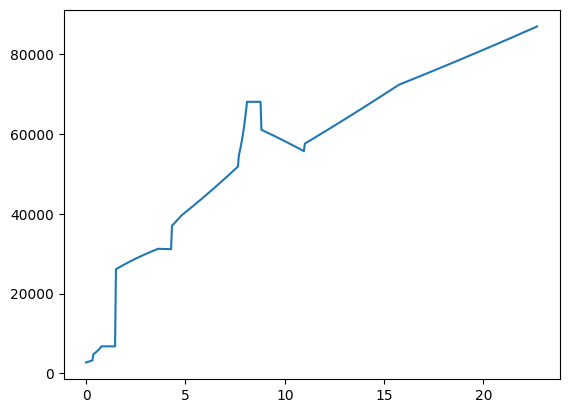

In [ ]:
import math
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root
import matplotlib.pyplot as plt


#Inputs Sand Layers
layers=[0, 1, 0, 0, 0]    #0 means clay and 1 means sand
layers_thickness=[1.5, 2.8, 4.5, 2.2, 11.7]
submerged_unit_weight=[5.5, 9.9, 9.9, 9.4, 7.2] #denoted as suw
su_friction=[(2.0, 4.0), 28, (18.0, 34.0), (70, 82), (38,64)]

#Inputs Spudcan
V_spud=300 #Volume of spudcan
Vd= 0 # Minimum volume of spudcan below the maximum diameter of spudcan, 0 for flat base
B= 14 #15.3 # Diameter of spudcan
Preload=45 # MN

#OBSERVATIONS:
##Linear and cubic in nc sc dc
###min max confusion in clay over clay plunge
####t tends to zero criteria in clay squeezing
#####Why decrease 5 degree in friction angle?
squeeze_factor=5
depth=[0]
d=0
for i in range(len(layers_thickness)):
  depth.append(d+layers_thickness[i])
  d=depth[-1]

incremental_depth=np.linspace(0,depth[-1],500)


def h_cav_func(su):
  B=15.3
  H_cav=layers_thickness[0]*(su-su_friction[0][0])/(su_friction[0][1]-(su_friction[0][0]+0.00001))
  suw=submerged_unit_weight[0]
  return (su / suw / B) ** 0.55 - 0.25 * (su / suw / B) - H_cav/B


def h_cavitation(s_um=su_friction[0][0]):
  multilayer_clay=False
  if layers[0]+layers[1]==0:
    multilayer_clay=True
  suw=submerged_unit_weight[0]
  rho=(su_friction[0][1]-su_friction[0][0])/layers_thickness[0]
  S=(s_um/suw/B)**(1-rho/suw)
  if multilayer_clay==False:
    return B*(S**0.55-0.25*S)

  if multilayer_clay==True:
    solution=root(h_cav_func, x0=5.0)
    su_final=solution.x[0]
    suw=submerged_unit_weight[0]
    return max(B*((su_final/suw/B)**0.55-0.25*(su_final/suw/B)), B*(S**0.55-0.25*S))

h_cav=h_cavitation()

#print(h_cav)

def nc_sc_dc(x):
  if x>=2.5:return 9.0
  x_data=[0, 0.1, 0.25, 0.5, 1.0, 2.5]
  y_data=[6.0, 6.3, 6.6, 7.1, 7.7, 9.0]
  interpolated_function = interp1d(x_data, y_data, kind='cubic')    #As mentioned in API that it is not linear
  return interpolated_function(x)

def n_gamma(x):
  x_data=np.linspace(20,40,21)
  y_data=[2.4, 2.9, 3.5, 4.2, 5.1, 6.1, 7.3, 8.8, 10.6, 12.8, 15.5, 18.8, 22.9, 27.9, 34.1, 41.9, 51.6, 63.7, 79.1, 98.7, 123.7]
  interpolated_function = interp1d(x_data, y_data, kind='cubic', fill_value="extrapolate")
  return interpolated_function(x)

def nq(x):
  x_data=np.linspace(20,40,21)
  y_data=[96, 10.9, 12.4, 14.1, 16.1, 18.4, 21.1, 24.2, 27.9, 32.2, 37.2, 43.2, 50.3, 58.7, 68.7, 80.8, 95.4, 113.0, 134.4, 160.5, 192.7]
  interpolated_function = interp1d(x_data, y_data, kind='cubic', fill_value="extrapolate")
  return interpolated_function(x)


def average_su(d, delta_d=B/2, layer_status="same"):  #layer_status= same or all
  d_start=d
  d_end=d+delta_d


  if layer_status=="same":
    for i in range(len(depth)):
      if i<len(depth)-1 and d_start>=depth[i] and d_start<=depth[i+1]:
        if d_end>depth[i+1]:
          d_end=depth[i+1]
          break
        elif d_end>depth[i+1]:
          break


  #incremental_depth=np.linspace(0,depth[-1],500)
  #print(incremental_depth)
  su_all=[]


  for j in range(len(depth)-1):
    for i in incremental_depth:
      if i >= depth[j] and i< depth[j+1] and layers[j]==1:
        #print(i)
        su_all.append(0)
      elif i >= depth[j] and i<= depth[j+1]and layers[j]==0:
        su_all.append(su_friction[j][0]+(i-depth[j])/(depth[j+1]-depth[j])*(su_friction[j][1]-su_friction[j][0]))
        #print(su_all)
      elif i>depth[j+1]:
        break
  #print(len(su_all))
  #print(len(incremental_depth))
  su_list=[]
  for i in range(len(incremental_depth)):
    #print(su_all[i])
    if incremental_depth[i]>d_start and incremental_depth[i]<d_end and su_all[i]==0:
      #su_list.append(0)
      break
    if incremental_depth[i]>=d_start and incremental_depth[i]<=d_end and su_all[i]!=0:
      su_list.append(su_all[i])

  #print(su_all)
  if len(su_list)!=0:
    su_avg_final=sum(su_list)/len(su_list)
    return su_avg_final
  return 0

  #print(su_all)

#print(average_su(28.60))
#print(len(su_all))
#print(len(incremental_depth))
def calculate_incremental_average(layer_status='same'):
  incremental_su_average=[]
  for i in range(len(incremental_depth)):
    if average_su(incremental_depth[i])!=0:
      incremental_su_average.append(average_su(incremental_depth[i], layer_status=layer_status))
    else:
      incremental_su_average.append(0)
  return incremental_su_average

incremental_su_average=calculate_incremental_average()
#print(incremental_su_average)

incremental_friction=[]
for j in range(len(depth)-1):
  for i in range(len(incremental_depth)):
    if layers[j]==1 and incremental_depth[i]>=depth[j] and incremental_depth[i]<=depth[j+1] :
      incremental_friction.append(su_friction[j])
    elif layers[j]==0 and incremental_depth[i]>=depth[j] and incremental_depth[i]<=depth[j+1] :
      incremental_friction.append(0)
#print(incremental_friction)

incremental_po_dash=[0]
temp_po=0
for j in range(len(depth)-1):
  for i in range(1,len(incremental_depth)):
    if incremental_depth[i]>=depth[j] and incremental_depth[i]<=depth[j+1]:
      incremental_po_dash.append((incremental_depth[i]-incremental_depth[i-1])*submerged_unit_weight[j]+temp_po)
      temp_po=(incremental_depth[i]-incremental_depth[i-1])*submerged_unit_weight[j]+temp_po
    elif incremental_depth[i]>depth[j+1]:
      break
#print(incremental_po_dash)

incremental_gamma=[]
for j in range(len(depth)-1):
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=depth[j] and incremental_depth[i]<=depth[j+1]:
      incremental_gamma.append(submerged_unit_weight[j])
    elif incremental_depth[i]>depth[j+1]:
      break
#print(len(incremental_gamma))

incremental_T=[]
for j in range(len(depth)-1):
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=depth[j] and incremental_depth[i]<=depth[j+1]:
      incremental_T.append(depth[j+1]-incremental_depth[i])
    elif incremental_depth[i]>depth[j+1]:
      break
#print(len(incremental_T))


incremental_vl=[0]*len(incremental_depth)

def clay_penetration(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      #print(incremental_po_dash[i])
      if (1+0.2*incremental_depth[i]/B)>1.5:
        DB_factor=1.5
      else:
        DB_factor=(1+0.2*incremental_depth[i]/B)
      incremental_qv=(6*incremental_su_average[i]*DB_factor+incremental_po_dash[i])*3.14159*B**2/4
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_squeezing(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      if B>=3.45*incremental_T[i]*(1+1.025*max(incremental_depth[i]/B, 2.5)) and incremental_T[i]>=squeeze_factor/100*B: #EXCEL SHEET max(2.5) is not considered, IMPROVE
        # T is assumed as greater than 1% of B, take maximum up till now
        qv1=3.14159*B**2/4*((5.0+ 0.33*B/incremental_T[i]+ 1.2*incremental_depth[i]/B)*incremental_su_average[i]+ incremental_po_dash[i])
        qv2=(incremental_su_average[i]*nc_sc_dc(incremental_depth[i]/B)+incremental_po_dash[i])*3.14159*B**2/4
        qv=max(qv1,qv2)
        incremental_qv=qv
        incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
        incremental_bs=incremental_gamma[i]*Vd
        incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs

      elif B>=3.45*incremental_T[i]*(1+1.025*max(incremental_depth[i]/B, 2.5)) and incremental_T[i]<squeeze_factor/100*B:
        incremental_vl[i]=max(incremental_vl)

      else:
        qv=(6*incremental_su_average[i]*(1+incremental_depth[i]/B)+incremental_po_dash[i])*3.14159*B**2/4
        incremental_qv=qv
        incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
        incremental_bs=incremental_gamma[i]*Vd
        incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
      #incremental_qv=qv
      #incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      #incremental_bs=incremental_gamma[i]*Vd
      #incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs


    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_squeezing_iso(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      if incremental_T[i]>=squeeze_factor/100*B:
        # T is assumed as greater than 1% of B, take maximum up till now
        qv1=3.14159*B**2/4*((5.0+ 0.33*B/incremental_T[i]+ 1.2*incremental_depth[i]/B)*incremental_su_average[i]+ incremental_po_dash[i])
        qv2=(incremental_su_average[i]*nc_sc_dc(incremental_depth[i]/B)+incremental_po_dash[i])*3.14159*B**2/4
        qv=max(qv1,qv2)
        incremental_qv=qv
        incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
        incremental_bs=incremental_gamma[i]*Vd
        incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs

      else:
        incremental_vl[i]=max(incremental_vl)

    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_squeezing_skempton(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      qv=(incremental_su_average[i]*nc_sc_dc(incremental_depth[i]/B)+incremental_po_dash[i])*3.14159*B**2/4
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs

    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_over_clay_punch(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 and incremental_depth[i]<=B:
      su_b=average_su(D2+incremental_depth[1]-incremental_depth[0])
      #Brown Method
      qv1=3.14159*B**2/4*(3*incremental_T[i]/B*incremental_su_average[i]+6*su_b*(1+0.2*(incremental_depth[i]+incremental_T[i])/B)+incremental_po_dash[i])
      #qv2=3.14159*B**2/4*6*incremental_su_average[i]


      #For Projected area method:
      ns=5
      b_dash=B+2*incremental_T[i]/ns
      d_dash=(incremental_T[i]+incremental_depth[i])
      if (1+0.2*d_dash/b_dash)>=1.5:
        DB_factor=1.5
      else:
        DB_factor= (1+0.2*d_dash/b_dash)
      su_b=average_su(D2+incremental_depth[1]-incremental_depth[0])
      qv2=3.14159*b_dash**2/4*(su_b*6*DB_factor+incremental_po_dash[i])

      qv=min(qv1,qv2)


      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
    elif incremental_depth[i]>=D1 and incremental_depth[i]<=D2 and incremental_depth[i]>B:
      #Skempton method
      if (1+0.2*incremental_depth[i]/B)>=1.5:
        DB_factor=1.5
      else:
        DB_factor= (1+0.2*incremental_depth[i]/B)
      qv=3.14159*B**2/4*(6*incremental_su_average[i]*DB_factor+incremental_po_dash[i])
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_over_clay_punch_projected_area(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      #For Projected area method:
      ns=5
      b_dash=B+2*incremental_T[i]/ns
      d_dash=(incremental_T[i]+incremental_depth[i])
      if (1+0.2*d_dash/b_dash)>=1.5:
        DB_factor=1.5
      else:
        DB_factor= (1+0.2*d_dash/b_dash)
      su_b=average_su(D2+incremental_depth[1]-incremental_depth[0])
      qv=3.14159*b_dash**2/4*(su_b*6*DB_factor+incremental_po_dash[i])

      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_over_clay_punch_brown(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      su_b=average_su(D2+incremental_depth[1]-incremental_depth[0])
      #Brown Method
      qv=3.14159*B**2/4*(3*incremental_T[i]/B*incremental_su_average[i]+6*su_b*(1+0.2*(incremental_depth[i]+incremental_T[i])/B)+incremental_po_dash[i])

      #Conservative criteria since Su_weak is taken as the the Su_average at the top of the weak clay
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_over_clay_punch_skempton(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      #Skempton method
      if (1+0.2*incremental_depth[i]/B)>=1.5:
        DB_factor=1.5
      else:
        DB_factor= (1+0.2*incremental_depth[i]/B)
      qv=3.14159*B**2/4*(6*incremental_su_average[i]*DB_factor+incremental_po_dash[i])
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_penetration(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 :
      #ISO
      dq=1+2*np.tan(math.radians(incremental_friction[i])*(1-np.sin(math.radians(incremental_friction[i])))**2*np.arctan(incremental_depth[i]/B))
      n_gamma_value=n_gamma(incremental_friction[i])
      nq_value=nq(incremental_friction[i])
      dy_value=1.0
      qv1=incremental_gamma[i]*dy_value*n_gamma_value*3.14159*B**3/8 +incremental_po_dash[i]*dq*nq_value*3.14159*B**2/4
      #McCelland Method
      ny_value=1.0
      qv2=(incremental_gamma[i]*0.3*B*ny_value+incremental_po_dash[i]*nq_value+ incremental_gamma[i]*V_spud/(3.14159*B**2/4))*(3.14159*B**2/4)
      qv=min(qv1,qv2)
      incremental_qv=qv
      #incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_penetration_iso(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 :
      dq=1+2*np.tan(math.radians(incremental_friction[i])*(1-np.sin(math.radians(incremental_friction[i])))**2*np.arctan(incremental_depth[i]/B))
      n_gamma_value=n_gamma(incremental_friction[i])
      nq_value=nq(incremental_friction[i])
      dy_value=1.0
      qv=incremental_gamma[i]*dy_value*n_gamma_value*3.14159*B**3/8 +incremental_po_dash[i]*dq*nq_value*3.14159*B**2/4
      incremental_qv=qv
      #incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_penetration_mc(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 :
      dq=1+2*np.tan(math.radians(incremental_friction[i])*(1-np.sin(math.radians(incremental_friction[i])))**2*np.arctan(incremental_depth[i]/B))
      n_gamma_value=n_gamma(incremental_friction[i])
      nq_value=nq(incremental_friction[i])
      ny_value=1.0
      qv=(incremental_gamma[i]*0.3*B*ny_value+incremental_po_dash[i]*nq_value+ incremental_gamma[i]*V_spud/(3.14159*B**2/4))*(3.14159*B**2/4)
      incremental_qv=qv
      #incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_over_clay_punch(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 and incremental_depth[i]>=B:
      #Sand Penetration
      dy_value=1.0
      dq=1+2*np.tan(math.radians(incremental_friction[i])*(1-np.sin(math.radians(incremental_friction[i])))**2*np.arctan(incremental_depth[i]/B)) #THIS IS WRITTEN WRONG IN EXCEL SHEET
      n_gamma_value=n_gamma(incremental_friction[i])
      nq_value=nq(incremental_friction[i])
      qv1=incremental_gamma[i]*dy_value*n_gamma_value*3.14159*B**3/8 +incremental_po_dash[i]*dq*nq_value*3.14159*B**2/4
      #McCelland Method
      ny_value=10.6
      qv2=(incremental_gamma[i]*0.3*B*ny_value+incremental_po_dash[i]*nq_value+ incremental_gamma[i]*V_spud/(3.14159*B**2/4))*(3.14159*B**2/4)
      qv3=min(qv1,qv2)


      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv +incremental_bs - incremental_bf
    elif incremental_depth[i]>=D1 and incremental_depth[i]<=D2 and incremental_depth[i]<B:
      #Punch Through ISO
      ns=5
      W=0.25*3.14159*(B+incremental_T[i]/ns*2)**2*incremental_T[i]*incremental_gamma[i]
      su_clay=average_su(D2+incremental_depth[1]-incremental_depth[0])
      qv1=(su_clay*nc_sc_dc(incremental_depth[i]/B)+incremental_po_dash[i])*3.14159*(B+incremental_T[i]/ns*2)**2/4 -W

      #Projected Area
      ns=5
      b_dash=B+2*incremental_T[i]/ns
      d_dash=(incremental_T[i]+incremental_depth[i])
      qv2=3.14159*b_dash**2/4*(su_clay*6*(1+0.2*d_dash/b_dash)+incremental_po_dash[i])
      qv=min(qv1,qv2)
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs-incremental_bf
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_over_clay_punch_penetration(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      #Sand Penetration
      dy_value=1.0
      dq=1+2*np.tan(math.radians(incremental_friction[i])*(1-np.sin(math.radians(incremental_friction[i])))**2*np.arctan(incremental_depth[i]/B)) #THIS IS WRITTEN WRONG IN EXCEL SHEET
      n_gamma_value=n_gamma(incremental_friction[i])
      nq_value=nq(incremental_friction[i])
      qv=incremental_gamma[i]*dy_value*n_gamma_value*3.14159*B**3/8 +incremental_po_dash[i]*dq*nq_value*3.14159*B**2/4
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs-incremental_bf
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_over_clay_punch_mc(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      ny_value=10.6
      dq=1+2*np.tan(math.radians(incremental_friction[i])*(1-np.sin(math.radians(incremental_friction[i])))**2*np.arctan(incremental_depth[i]/B))
      n_gamma_value=n_gamma(incremental_friction[i])
      nq_value=nq(incremental_friction[i])
      #McCelland Method
      qv=(incremental_gamma[i]*0.3*B*ny_value+incremental_po_dash[i]*nq_value+ incremental_gamma[i]*V_spud/(3.14159*B**2/4))*(3.14159*B**2/4)
      incremental_qv=qv
      incremental_bs=incremental_gamma[i]*Vd
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_vl[i]=incremental_qv+incremental_bs-incremental_bf
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_over_clay_punch_iso(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 and incremental_depth[i]<B:
      #Punch Through ISO
      ns=3
      W=0.25*3.14159*(B+2*incremental_T[i]/ns)**2*incremental_T[i]*incremental_gamma[i]
      su_clay=average_su(D2+incremental_depth[1]-incremental_depth[0])
      qv=(su_clay*nc_sc_dc(incremental_depth[i]/B)+incremental_po_dash[i])*3.14159*(B+2*incremental_T[i]/ns)**2/4 -W
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs-incremental_bf
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_over_clay_punch_projected(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 and incremental_depth[i]<B:
      #Projected Area
      ns=5
      b_dash=B+2*incremental_T[i]/ns
      d_dash=(incremental_T[i]+incremental_depth[i])
      qv=3.14159*B**2/4*(6*incremental_su_average[i]*(1+0.2*d_dash/b_dash)+incremental_po_dash[i])
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs-incremental_bf
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_over_clay_punch_hanna(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      #Hanna
      su_clay=average_su(D2+incremental_depth[1]-incremental_depth[0])
      Ks=3.5
      qu=6*su_clay+ 2*incremental_gamma[i]*incremental_T[i]**2*(1+2*incremental_depth[i]/incremental_T[i])*Ks*np.tan(math.radians(incremental_friction[i]))/B + incremental_gamma[i]*V_spud/(3.14159*B**2/4)
      qv=qu*3.14159*B**2/4
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs-incremental_bf
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

#sand_over_clay_punch(26.4,28.7)
#0 means penetration in clay
#1 means squeezing in clay
#2 means clay over clay punch through
#3 means penetration in sand
#4 means sand over play punch through
def layer_sequence():
  possible_failures=[]
  for i in range(len(layers)):
    if layers[i]==0 and i==len(layers)-1:
      possible_failures.append([(0,"all")])
    elif layers[i]==1 and i==len(layers)-1:
      possible_failures.append([(3,"all")])
    elif layers[i]==0 and i<len(layers)-1 and layers[i+1]==1:
      possible_failures.append([(0,"all"),(1,"all")])
    elif layers[i]==0 and i<len(layers)-1 and layers[i+1]==0 and (np.abs(su_friction[i+1][0]-su_friction[i][1])<=25): #and su_friction[i+1][0]<1.5*su_friction[i][1]):
      #50% bound criteria
      possible_failures.append([(0,"all")])  #[0]
    elif layers[i]==0 and i<len(layers)-1 and layers[i+1]==0 and (su_friction[i][1]-su_friction[i+1][0]>25):
      #50% bound criteria
      possible_failures.append([(0,"same"),(2,"same")])
    elif layers[i]==0 and i<len(layers)-1 and layers[i+1]==0 and (su_friction[i+1][0]-su_friction[i][1]>25):
      #50% bound criteria
      possible_failures.append([(0,"same"),(1,"same")])
    elif layers[i]==1 and i<len(layers)-1 and layers[i+1]==1:
      possible_failures.append([(3,"all")])
    elif layers[i]==1 and i<len(layers)-1 and layers[i+1]==0:
      possible_failures.append([(3,"all"), (4,"all")])    #Earlier it was [3,4]

  VL=[0]*len(incremental_depth)
  for layer_no in range(len(possible_failures)):
    VL_min=[]
    for (i,j) in possible_failures[layer_no]:
        if i==0:
            VL_temp, VL_min_temp=clay_penetration(depth[layer_no],depth[layer_no+1],VL, layer_status=j)
            VL_min.append(VL_min_temp)
            if VL_min_temp==min(VL_min):
              VL=VL_temp
        elif i==1:
            VL_temp, VL_min_temp=clay_squeezing(depth[layer_no],depth[layer_no+1],VL, layer_status=j)
            VL_min.append(VL_min_temp)
            if VL_min_temp==min(VL_min):
              VL=VL_temp
        elif i==2:
            VL_temp, VL_min_temp=clay_over_clay_punch(depth[layer_no],depth[layer_no+1],VL, layer_status=j)
            VL_min.append(VL_min_temp)
            if VL_min_temp==min(VL_min):
              VL=VL_temp
        elif i==3:
            VL_temp, VL_min_temp=sand_penetration(depth[layer_no],depth[layer_no+1],VL, layer_status=j)
            VL_min.append(VL_min_temp)
            if VL_min_temp==min(VL_min):
              VL=VL_temp
        elif i==4:
            VL_temp, VL_min_temp=sand_over_clay_punch(depth[layer_no],depth[layer_no+1],VL, layer_status=j)
            VL_min.append(VL_min_temp)
            if VL_min_temp==min(VL_min):
              VL=VL_temp

  return VL


VL=layer_sequence()
fig, ax=plt.subplots()
ax.plot(incremental_depth, VL)
plt.show()
#for i in range(len(incremental_depth)):
#  print(round(incremental_depth[i],1), round(VL[i],0))

In [ ]:
#Doubts to ask:
# Why is H cavitation taken as 0 in the sheet? Should not it be 2.8 something. It is used in backfill calculations
# How to estimate Ny and Ks used in Sand over Clay punch-through?
# Squeeze depth?

In [ ]:
import math
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, NearestNDInterpolator
import pandas as pd


#Inputs Sand Layers
layers=[0, 1, 0, 0, 0]    #0 means clay and 1 means sand
layers_thickness=[1.5, 2.8, 4.5, 2.2, 11.7]
submerged_unit_weight=[5.5, 9.9, 9.9, 9.4, 7.2] #denoted as suw
su_friction=[(2.0, 4.0), 28, (18.0, 34.0), (70, 82), (38,64)]

#Inputs Spudcan
V_spud=300 #Volume of spudcan
Vd= 0 # Minimum volume of spudcan below the maximum diameter of spudcan, 0 for flat base
B= 14 #15.3 # Diameter of spudcan
Preload=45 # MN

#OBSERVATIONS:
##Linear and cubic in nc sc dc
###min max confusion in clay over clay plunge
####t tends to zero criteria in clay squeezing
#####Why decrease 5 degree in friction angle?
squeeze_factor=5
depth=[0]
d=0
for i in range(len(layers_thickness)):
  depth.append(d+layers_thickness[i])
  d=depth[-1]

incremental_depth=np.linspace(0,depth[-1],500)


def h_cav_func(su):
  B=15.3
  H_cav=layers_thickness[0]*(su-su_friction[0][0])/(su_friction[0][1]-(su_friction[0][0]+0.00001))
  suw=submerged_unit_weight[0]
  return (su / suw / B) ** 0.55 - 0.25 * (su / suw / B) - H_cav/B


def h_cavitation(s_um=su_friction[0][0]):
  multilayer_clay=False
  if layers[0]+layers[1]==0:
    multilayer_clay=True
  suw=submerged_unit_weight[0]
  rho=(su_friction[0][1]-su_friction[0][0])/layers_thickness[0]
  S=(s_um/suw/B)**(1-rho/suw)
  if multilayer_clay==False:
    return B*(S**0.55-0.25*S)

  if multilayer_clay==True:
    solution=root(h_cav_func, x0=5.0)
    su_final=solution.x[0]
    suw=submerged_unit_weight[0]
    return max(B*((su_final/suw/B)**0.55-0.25*(su_final/suw/B)), B*(S**0.55-0.25*S))

h_cav=h_cavitation()

#print(h_cav)

def nc_sc_dc(x):
  if x>=2.5:return 9.0
  x_data=[0, 0.1, 0.25, 0.5, 1.0, 2.5]
  y_data=[6.0, 6.3, 6.6, 7.1, 7.7, 9.0]
  interpolated_function = interp1d(x_data, y_data, kind='cubic')    #As mentioned in API that it is not linear
  return interpolated_function(x)

def n_gamma(x):
  x_data=np.linspace(20,40,21)
  y_data=[2.4, 2.9, 3.5, 4.2, 5.1, 6.1, 7.3, 8.8, 10.6, 12.8, 15.5, 18.8, 22.9, 27.9, 34.1, 41.9, 51.6, 63.7, 79.1, 98.7, 123.7]
  interpolated_function = interp1d(x_data, y_data, kind='cubic', fill_value="extrapolate")
  return interpolated_function(x)

def nq(x):
  x_data=np.linspace(20,40,21)
  y_data=[96, 10.9, 12.4, 14.1, 16.1, 18.4, 21.1, 24.2, 27.9, 32.2, 37.2, 43.2, 50.3, 58.7, 68.7, 80.8, 95.4, 113.0, 134.4, 160.5, 192.7]
  interpolated_function = interp1d(x_data, y_data, kind='cubic', fill_value="extrapolate")
  return interpolated_function(x)


friction_angles=[40,35,30,25]
points=[]
values=[]
for i in range(len(friction_angles)):
  df=pd.read_excel("Ks Factor.xlsx", sheet_name=i)
  columns=df.columns
  temp_strength=df[columns[0]].astype(float).to_list()
  temp_ks=df[columns[1]].astype(float).to_list()
  for j in range(len(temp_strength)):
    points.append([temp_strength[j],friction_angles[i]])
    values.append(temp_ks[j])


def ks_factor(strength_ratio, friction_angle):
    target_point=np.array([[strength_ratio,friction_angle]])
    interpolated_ks = griddata(np.array(points), np.array(values), target_point, method='linear')

    if np.isnan(interpolated_ks):
        interp = NearestNDInterpolator(points, values)
        interpolated_ks = interp([strength_ratio,friction_angle])

    return interpolated_ks



print(ks_factor(0.4, 20))

def average_su(d, delta_d=B/2, layer_status="same"):  #layer_status= same or all
  d_start=d
  d_end=d+delta_d


  if layer_status=="same":
    for i in range(len(depth)):
      if i<len(depth)-1 and d_start>=depth[i] and d_start<=depth[i+1]:
        if d_end>depth[i+1]:
          d_end=depth[i+1]
          break
        elif d_end>depth[i+1]:
          break


  #incremental_depth=np.linspace(0,depth[-1],500)
  #print(incremental_depth)
  su_all=[]


  for j in range(len(depth)-1):
    for i in incremental_depth:
      if i >= depth[j] and i< depth[j+1] and layers[j]==1:
        #print(i)
        su_all.append(0)
      elif i >= depth[j] and i<= depth[j+1]and layers[j]==0:
        su_all.append(su_friction[j][0]+(i-depth[j])/(depth[j+1]-depth[j])*(su_friction[j][1]-su_friction[j][0]))
        #print(su_all)
      elif i>depth[j+1]:
        break
  #print(len(su_all))
  #print(len(incremental_depth))
  su_list=[]
  for i in range(len(incremental_depth)):
    #print(su_all[i])
    if incremental_depth[i]>d_start and incremental_depth[i]<d_end and su_all[i]==0:
      #su_list.append(0)
      break
    if incremental_depth[i]>=d_start and incremental_depth[i]<=d_end and su_all[i]!=0:
      su_list.append(su_all[i])

  #print(su_all)
  if len(su_list)!=0:
    su_avg_final=sum(su_list)/len(su_list)
    return su_avg_final
  return 0

  #print(su_all)

#print(average_su(28.60))
#print(len(su_all))
#print(len(incremental_depth))
def calculate_incremental_average(layer_status='same'):
  incremental_su_average=[]
  for i in range(len(incremental_depth)):
    if average_su(incremental_depth[i])!=0:
      incremental_su_average.append(average_su(incremental_depth[i], layer_status=layer_status))
    else:
      incremental_su_average.append(0)
  return incremental_su_average

incremental_su_average=calculate_incremental_average()
#print(incremental_su_average)

incremental_friction=[]
for j in range(len(depth)-1):
  for i in range(len(incremental_depth)):
    if layers[j]==1 and incremental_depth[i]>=depth[j] and incremental_depth[i]<=depth[j+1] :
      incremental_friction.append(su_friction[j])
    elif layers[j]==0 and incremental_depth[i]>=depth[j] and incremental_depth[i]<=depth[j+1] :
      incremental_friction.append(0)
#print(incremental_friction)

incremental_po_dash=[0]
temp_po=0
for j in range(len(depth)-1):
  for i in range(1,len(incremental_depth)):
    if incremental_depth[i]>=depth[j] and incremental_depth[i]<=depth[j+1]:
      incremental_po_dash.append((incremental_depth[i]-incremental_depth[i-1])*submerged_unit_weight[j]+temp_po)
      temp_po=(incremental_depth[i]-incremental_depth[i-1])*submerged_unit_weight[j]+temp_po
    elif incremental_depth[i]>depth[j+1]:
      break
#print(incremental_po_dash)

incremental_gamma=[]
for j in range(len(depth)-1):
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=depth[j] and incremental_depth[i]<=depth[j+1]:
      incremental_gamma.append(submerged_unit_weight[j])
    elif incremental_depth[i]>depth[j+1]:
      break
#print(len(incremental_gamma))

incremental_T=[]
for j in range(len(depth)-1):
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=depth[j] and incremental_depth[i]<=depth[j+1]:
      incremental_T.append(depth[j+1]-incremental_depth[i])
    elif incremental_depth[i]>depth[j+1]:
      break
#print(len(incremental_T))


incremental_vl=[0]*len(incremental_depth)

def clay_penetration(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      #print(incremental_po_dash[i])
      if (1+0.2*incremental_depth[i]/B)>1.5:
        DB_factor=1.5
      else:
        DB_factor=(1+0.2*incremental_depth[i]/B)
      incremental_qv=(6*incremental_su_average[i]*DB_factor+incremental_po_dash[i])*3.14159*B**2/4
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_squeezing(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      if B>=3.45*incremental_T[i]*(1+1.025*max(incremental_depth[i]/B, 2.5)) and incremental_T[i]>=squeeze_factor/100*B: #EXCEL SHEET max(2.5) is not considered, IMPROVE
        # T is assumed as greater than 1% of B, take maximum up till now
        qv1=3.14159*B**2/4*((5.0+ 0.33*B/incremental_T[i]+ 1.2*incremental_depth[i]/B)*incremental_su_average[i]+ incremental_po_dash[i])
        qv2=(incremental_su_average[i]*nc_sc_dc(incremental_depth[i]/B)+incremental_po_dash[i])*3.14159*B**2/4
        qv=max(qv1,qv2)
        incremental_qv=qv
        incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
        incremental_bs=incremental_gamma[i]*Vd
        incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs

      elif B>=3.45*incremental_T[i]*(1+1.025*max(incremental_depth[i]/B, 2.5)) and incremental_T[i]<squeeze_factor/100*B:
        incremental_vl[i]=max(incremental_vl)

      else:
        qv=(6*incremental_su_average[i]*(1+incremental_depth[i]/B)+incremental_po_dash[i])*3.14159*B**2/4
        incremental_qv=qv
        incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
        incremental_bs=incremental_gamma[i]*Vd
        incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
      #incremental_qv=qv
      #incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      #incremental_bs=incremental_gamma[i]*Vd
      #incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs


    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_squeezing_iso(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      if incremental_T[i]>=squeeze_factor/100*B:
        # T is assumed as greater than 1% of B, take maximum up till now
        qv1=3.14159*B**2/4*((5.0+ 0.33*B/incremental_T[i]+ 1.2*incremental_depth[i]/B)*incremental_su_average[i]+ incremental_po_dash[i])
        qv2=(incremental_su_average[i]*nc_sc_dc(incremental_depth[i]/B)+incremental_po_dash[i])*3.14159*B**2/4
        qv=max(qv1,qv2)
        incremental_qv=qv
        incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
        incremental_bs=incremental_gamma[i]*Vd
        incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs

      else:
        incremental_vl[i]=max(incremental_vl)

    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_squeezing_skempton(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      qv=(incremental_su_average[i]*nc_sc_dc(incremental_depth[i]/B)+incremental_po_dash[i])*3.14159*B**2/4
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs

    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_over_clay_punch(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 and incremental_depth[i]<=B:
      su_b=average_su(D2+incremental_depth[1]-incremental_depth[0])
      #Brown Method
      qv1=3.14159*B**2/4*(3*incremental_T[i]/B*incremental_su_average[i]+6*su_b*(1+0.2*(incremental_depth[i]+incremental_T[i])/B)+incremental_po_dash[i])
      #qv2=3.14159*B**2/4*6*incremental_su_average[i]


      #For Projected area method:
      ns=5
      b_dash=B+2*incremental_T[i]/ns
      d_dash=(incremental_T[i]+incremental_depth[i])
      if (1+0.2*d_dash/b_dash)>=1.5:
        DB_factor=1.5
      else:
        DB_factor= (1+0.2*d_dash/b_dash)
      su_b=average_su(D2+incremental_depth[1]-incremental_depth[0])
      qv2=3.14159*b_dash**2/4*(su_b*6*DB_factor+incremental_po_dash[i])

      qv=min(qv1,qv2)


      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
    elif incremental_depth[i]>=D1 and incremental_depth[i]<=D2 and incremental_depth[i]>B:
      #Skempton method
      if (1+0.2*incremental_depth[i]/B)>=1.5:
        DB_factor=1.5
      else:
        DB_factor= (1+0.2*incremental_depth[i]/B)
      qv=3.14159*B**2/4*(6*incremental_su_average[i]*DB_factor+incremental_po_dash[i])
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_over_clay_punch_projected_area(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      #For Projected area method:
      ns=5
      b_dash=B+2*incremental_T[i]/ns
      d_dash=(incremental_T[i]+incremental_depth[i])
      if (1+0.2*d_dash/b_dash)>=1.5:
        DB_factor=1.5
      else:
        DB_factor= (1+0.2*d_dash/b_dash)
      su_b=average_su(D2+incremental_depth[1]-incremental_depth[0])
      qv=3.14159*b_dash**2/4*(su_b*6*DB_factor+incremental_po_dash[i])

      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_over_clay_punch_brown(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      su_b=average_su(D2+incremental_depth[1]-incremental_depth[0])
      #Brown Method
      qv=3.14159*B**2/4*(3*incremental_T[i]/B*incremental_su_average[i]+6*su_b*(1+0.2*(incremental_depth[i]+incremental_T[i])/B)+incremental_po_dash[i])

      #Conservative criteria since Su_weak is taken as the the Su_average at the top of the weak clay
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def clay_over_clay_punch_skempton(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      #Skempton method
      if (1+0.2*incremental_depth[i]/B)>=1.5:
        DB_factor=1.5
      else:
        DB_factor= (1+0.2*incremental_depth[i]/B)
      qv=3.14159*B**2/4*(6*incremental_su_average[i]*DB_factor+incremental_po_dash[i])
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv-incremental_bf+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_penetration(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 :
      #ISO
      dq=1+2*np.tan(math.radians(incremental_friction[i])*(1-np.sin(math.radians(incremental_friction[i])))**2*np.arctan(incremental_depth[i]/B))
      n_gamma_value=n_gamma(incremental_friction[i])
      nq_value=nq(incremental_friction[i])
      dy_value=1.0
      qv1=incremental_gamma[i]*dy_value*n_gamma_value*3.14159*B**3/8 +incremental_po_dash[i]*dq*nq_value*3.14159*B**2/4
      #McCelland Method
      qv2=(incremental_gamma[i]*0.3*B*n_gamma_value+incremental_po_dash[i]*nq_value+ incremental_gamma[i]*V_spud/(3.14159*B**2/4))*(3.14159*B**2/4)
      qv=min(qv1,qv2)
      incremental_qv=qv
      #incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_penetration_iso(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 :
      dq=1+2*np.tan(math.radians(incremental_friction[i])*(1-np.sin(math.radians(incremental_friction[i])))**2*np.arctan(incremental_depth[i]/B))
      n_gamma_value=n_gamma(incremental_friction[i])
      nq_value=nq(incremental_friction[i])
      dy_value=1.0
      qv=incremental_gamma[i]*dy_value*n_gamma_value*3.14159*B**3/8 +incremental_po_dash[i]*dq*nq_value*3.14159*B**2/4
      incremental_qv=qv
      #incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_penetration_mc(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 :
      dq=1+2*np.tan(math.radians(incremental_friction[i])*(1-np.sin(math.radians(incremental_friction[i])))**2*np.arctan(incremental_depth[i]/B))
      n_gamma_value=n_gamma(incremental_friction[i])
      nq_value=nq(incremental_friction[i])
      qv=(incremental_gamma[i]*0.3*B*n_gamma_value+incremental_po_dash[i]*nq_value+ incremental_gamma[i]*V_spud/(3.14159*B**2/4))*(3.14159*B**2/4)
      incremental_qv=qv
      #incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_over_clay_punch(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 and incremental_depth[i]>=B:
      #Sand Penetration
      dy_value=1.0
      dq=1+2*np.tan(math.radians(incremental_friction[i])*(1-np.sin(math.radians(incremental_friction[i])))**2*np.arctan(incremental_depth[i]/B)) #THIS IS WRITTEN WRONG IN EXCEL SHEET
      n_gamma_value=n_gamma(incremental_friction[i])
      nq_value=nq(incremental_friction[i])
      qv1=incremental_gamma[i]*dy_value*n_gamma_value*3.14159*B**3/8 +incremental_po_dash[i]*dq*nq_value*3.14159*B**2/4
      #McCelland Method
      qv2=(incremental_gamma[i]*0.3*B*n_gamma_value+incremental_po_dash[i]*nq_value+ incremental_gamma[i]*V_spud/(3.14159*B**2/4))*(3.14159*B**2/4)
      qv3=min(qv1,qv2)


      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv +incremental_bs - incremental_bf
    elif incremental_depth[i]>=D1 and incremental_depth[i]<=D2 and incremental_depth[i]<B:
      #Punch Through ISO
      ns=5
      W=0.25*3.14159*(B+incremental_T[i]/ns*2)**2*incremental_T[i]*incremental_gamma[i]
      su_clay=average_su(D2+incremental_depth[1]-incremental_depth[0])
      qv1=(su_clay*nc_sc_dc(incremental_depth[i]/B)+incremental_po_dash[i])*3.14159*(B+incremental_T[i]/ns*2)**2/4 -W

      #Projected Area
      ns=5
      b_dash=B+2*incremental_T[i]/ns
      d_dash=(incremental_T[i]+incremental_depth[i])
      qv2=3.14159*b_dash**2/4*(su_clay*6*(1+0.2*d_dash/b_dash)+incremental_po_dash[i])
      qv=min(qv1,qv2)
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs-incremental_bf
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_over_clay_punch_penetration(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      #Sand Penetration
      dy_value=1.0
      dq=1+2*np.tan(math.radians(incremental_friction[i])*(1-np.sin(math.radians(incremental_friction[i])))**2*np.arctan(incremental_depth[i]/B)) #THIS IS WRITTEN WRONG IN EXCEL SHEET
      n_gamma_value=n_gamma(incremental_friction[i])
      nq_value=nq(incremental_friction[i])
      qv=incremental_gamma[i]*dy_value*n_gamma_value*3.14159*B**3/8 +incremental_po_dash[i]*dq*nq_value*3.14159*B**2/4
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs-incremental_bf
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_over_clay_punch_mc(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      dq=1+2*np.tan(math.radians(incremental_friction[i])*(1-np.sin(math.radians(incremental_friction[i])))**2*np.arctan(incremental_depth[i]/B))
      n_gamma_value=n_gamma(incremental_friction[i])
      nq_value=nq(incremental_friction[i])
      #McCelland Method
      qv=(incremental_gamma[i]*0.3*B*n_gamma_value+incremental_po_dash[i]*nq_value+ incremental_gamma[i]*V_spud/(3.14159*B**2/4))*(3.14159*B**2/4)
      incremental_qv=qv
      incremental_bs=incremental_gamma[i]*Vd
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_vl[i]=incremental_qv+incremental_bs-incremental_bf
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_over_clay_punch_iso(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 and incremental_depth[i]<B:
      #Punch Through ISO
      ns=3
      W=0.25*3.14159*(B+2*incremental_T[i]/ns)**2*incremental_T[i]*incremental_gamma[i]
      su_clay=average_su(D2+incremental_depth[1]-incremental_depth[0])
      qv=(su_clay*nc_sc_dc(incremental_depth[i]/B)+incremental_po_dash[i])*3.14159*(B+2*incremental_T[i]/ns)**2/4 -W
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs-incremental_bf
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_over_clay_punch_projected(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2 and incremental_depth[i]<B:
      #Projected Area
      ns=5
      b_dash=B+2*incremental_T[i]/ns
      d_dash=(incremental_T[i]+incremental_depth[i])
      qv=3.14159*B**2/4*(6*incremental_su_average[i]*(1+0.2*d_dash/b_dash)+incremental_po_dash[i])
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs-incremental_bf
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

def sand_over_clay_punch_hanna(D1,D2,incremental_vl=[0]*len(incremental_depth),layer_status="all"):
  incremental_su_average=calculate_incremental_average(layer_status=layer_status)
  for i in range(len(incremental_depth)):
    if incremental_depth[i]>=D1 and incremental_depth[i]<=D2:
      #Hanna
      su_clay=average_su(D2+incremental_depth[1]-incremental_depth[0])
      Ks=3.5
      qu=6*su_clay+ 2*incremental_gamma[i]*incremental_T[i]**2*(1+2*incremental_depth[i]/incremental_T[i])*Ks*np.tan(math.radians(incremental_friction[i]))/B + incremental_gamma[i]*V_spud/(3.14159*B**2/4)
      qv=qu*3.14159*B**2/4
      incremental_qv=qv
      incremental_bf=max(incremental_gamma[i]*(3.14159*B**2/4*(incremental_depth[i]-h_cav)-(V_spud-Vd)),0.0)
      incremental_bs=incremental_gamma[i]*Vd
      incremental_vl[i]=incremental_qv+incremental_bs-incremental_bf
    elif incremental_depth[i]>D2:
      break
  return incremental_vl, max(incremental_vl)

#sand_over_clay_punch(26.4,28.7)
#0 means penetration in clay
#1 means squeezing in clay
#2 means clay over clay punch through
#3 means penetration in sand
#4 means sand over play punch through
def layer_sequence():
  possible_failures=[]
  for i in range(len(layers)):
    if layers[i]==0 and i==len(layers)-1:
      possible_failures.append([(0,"all")])
    elif layers[i]==1 and i==len(layers)-1:
      possible_failures.append([(3,"all")])
    elif layers[i]==0 and i<len(layers)-1 and layers[i+1]==1:
      possible_failures.append([(0,"all"),(1,"all")])
    elif layers[i]==0 and i<len(layers)-1 and layers[i+1]==0 and (np.abs(su_friction[i+1][0]-su_friction[i][1])<=25): #and su_friction[i+1][0]<1.5*su_friction[i][1]):
      #50% bound criteria
      possible_failures.append([(0,"all")])  #[0]
    elif layers[i]==0 and i<len(layers)-1 and layers[i+1]==0 and (su_friction[i][1]-su_friction[i+1][0]>25):
      #50% bound criteria
      possible_failures.append([(0,"same"),(2,"same")])
    elif layers[i]==0 and i<len(layers)-1 and layers[i+1]==0 and (su_friction[i+1][0]-su_friction[i][1]>25):
      #50% bound criteria
      possible_failures.append([(0,"same"),(1,"same")])
    elif layers[i]==1 and i<len(layers)-1 and layers[i+1]==1:
      possible_failures.append([(3,"all")])
    elif layers[i]==1 and i<len(layers)-1 and layers[i+1]==0:
      possible_failures.append([(3,"all"), (4,"all")])    #Earlier it was [3,4]

  VL=[0]*len(incremental_depth)
  for layer_no in range(len(possible_failures)):
    VL_min=[]
    for (i,j) in possible_failures[layer_no]:
        if i==0:
            VL_temp, VL_min_temp=clay_penetration(depth[layer_no],depth[layer_no+1],VL, layer_status=j)
            VL_min.append(VL_min_temp)
            if VL_min_temp==min(VL_min):
              VL=VL_temp
        elif i==1:
            VL_temp, VL_min_temp=clay_squeezing(depth[layer_no],depth[layer_no+1],VL, layer_status=j)
            VL_min.append(VL_min_temp)
            if VL_min_temp==min(VL_min):
              VL=VL_temp
        elif i==2:
            VL_temp, VL_min_temp=clay_over_clay_punch(depth[layer_no],depth[layer_no+1],VL, layer_status=j)
            VL_min.append(VL_min_temp)
            if VL_min_temp==min(VL_min):
              VL=VL_temp
        elif i==3:
            VL_temp, VL_min_temp=sand_penetration(depth[layer_no],depth[layer_no+1],VL, layer_status=j)
            VL_min.append(VL_min_temp)
            if VL_min_temp==min(VL_min):
              VL=VL_temp
        elif i==4:
            VL_temp, VL_min_temp=sand_over_clay_punch(depth[layer_no],depth[layer_no+1],VL, layer_status=j)
            VL_min.append(VL_min_temp)
            if VL_min_temp==min(VL_min):
              VL=VL_temp

  return VL


VL=layer_sequence()
fig, ax=plt.subplots()
ax.plot(incremental_depth, VL)
plt.show()
#for i in range(len(incremental_depth)):
#  print(round(incremental_depth[i],1), round(VL[i],0))